
Training a CNN on CIFAR10
=====================

In this notebook we use a CNN to train a model on the CIFAR10 dataset. 
This notebook follows the official PyTorch CNN tutorial which you can find [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

In [154]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [155]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [156]:
def confusion(prediction, truth):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

### 1. Load and inspect the data

In [157]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('..\\Data\\data_01_clean.csv',index_col='Unnamed: 0')

X=df.drop(columns=['Dev'])
y= df['Dev']

X = X.values # to numpy-array
y = y.values # to numpy-array


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)


In [158]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset=list(zip(X_train,y_train))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testset=list(zip(X_test,y_test))
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

classes = ('normal','Anomaly')

Let us show some of the training images, for fun.



### 2. Define a Convolutional Neural Network

In [159]:
# import torch.nn as nn
# import torch.nn.functional as F


# class DeepNeuralNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.hidden1 = nn.Linear(39, 4096)
#         self.hidden2 = nn.Linear(4096, 1000)
#         self.hidden3 = nn.Linear(1000, 2)

#     def forward(self, x):
        
#         z1 = self.hidden1(x)
#         a1 = torch.sigmoid(z1)
#         z2 = self.hidden2(a1)
#         a2 = torch.sigmoid(z2)
#         z3 = self.hidden3(a2)
#         return z3

In [160]:
import torch.nn as nn
import torch.nn.functional as F


class DeepNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(39, 4096)
        self.hidden2 = nn.Linear(4096, 8192)
        self.hidden3 = nn.Linear(8192, 1000)
        self.hidden4 = nn.Linear(1000, 100)
        self.hidden5 = nn.Linear(100, 2)

    def forward(self, x):
        
        z1 = self.hidden1(x)
        a1 = torch.sigmoid(z1)
        z2 = self.hidden2(a1)
        a2 = torch.sigmoid(z2)
        z3 = self.hidden3(a2)
        a3 = torch.sigmoid(z3)
        z4 = self.hidden4(a3)
        a4 = torch.sigmoid(z4)
        z5 = self.hidden5(a4)
        return z5

### 4. Train the network

In [161]:
import torch.optim as optim
import time

net = DeepNeuralNetwork()
net = net.float()
net.to(device)

train_losses = []
train_accuracy = []
test_accuracy  = []

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

start_time = time.time()
for epoch in range(15):

    running_loss = 0.0
    
    net.train()
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        inputs = inputs.to(device) #needed when using gpu
        labels = labels.to(device) #needed when using gpu

        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            train_losses.append(running_loss / 2000)
            running_loss = 0.0
            
        correct = 0
        
       
#---------------------------Test---Testing----------------------------------------------------------
    net.eval()   
     
    correct = 0
    total = 0
    
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device) #needed when using gpu
            labels = labels.to(device) #needed when using gpu
            
            # calculate outputs by running images through the network
            outputs = net(images.float())
            # the class with the highest energy is what we choose as prediction
            predicted = torch.argmax(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            test_accuracy.append(confusion(predicted, labels)+(epoch+1,))

    
#---------------------------Train---Testing----------------------------------------------------------

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images = images.to(device) #needed when using gpu
            labels = labels.to(device) #needed when using gpu
            
            # calculate outputs by running images through the network
            outputs = net(images.float())
            # the class with the highest energy is what we choose as prediction
            predicted = torch.argmax(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_accuracy.append(confusion(predicted, labels)+(epoch+1,))


print('Finished Training')
print(f'Time: {time.time() - start_time:.1f}s')

[1,  2000] loss: 0.389
[1,  4000] loss: 0.408
[1,  6000] loss: 0.396
[1,  8000] loss: 0.387
[1, 10000] loss: 0.389
[1, 12000] loss: 0.391
[1, 14000] loss: 0.391
[1, 16000] loss: 0.389
[1, 18000] loss: 0.401
[1, 20000] loss: 0.392
[1, 22000] loss: 0.399
[1, 24000] loss: 0.391
[1, 26000] loss: 0.397
[1, 28000] loss: 0.380
[1, 30000] loss: 0.405
[1, 32000] loss: 0.405
[1, 34000] loss: 0.400
[1, 36000] loss: 0.396
[1, 38000] loss: 0.403
[1, 40000] loss: 0.393
[1, 42000] loss: 0.379
[1, 44000] loss: 0.401
[1, 46000] loss: 0.391
[1, 48000] loss: 0.386
[1, 50000] loss: 0.398
[2,  2000] loss: 0.405
[2,  4000] loss: 0.391
[2,  6000] loss: 0.390
[2,  8000] loss: 0.385
[2, 10000] loss: 0.392
[2, 12000] loss: 0.396
[2, 14000] loss: 0.398
[2, 16000] loss: 0.386
[2, 18000] loss: 0.375
[2, 20000] loss: 0.386
[2, 22000] loss: 0.393
[2, 24000] loss: 0.389
[2, 26000] loss: 0.390
[2, 28000] loss: 0.397
[2, 30000] loss: 0.393
[2, 32000] loss: 0.379
[2, 34000] loss: 0.372
[2, 36000] loss: 0.388
[2, 38000] 

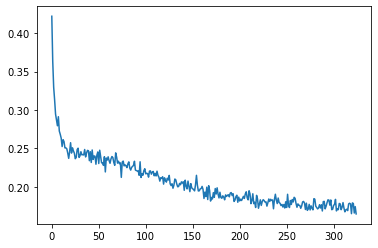

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label= "Training losses")

In [ ]:
res_df = pd.DataFrame(test_accuracy,columns=['true_positives', 'false_positives', 'true_negatives', 'false_negatives','epoch'])
res_df=res_df.groupby('epoch').agg({'true_positives':'sum', 'false_positives':'sum', 'true_negatives':'sum', 'false_negatives':'sum'}).reset_index()
res_df['accuracy']=(res_df['true_positives']+res_df['true_negatives'])/X_test.shape[0]
res_df['recall']=res_df['true_positives']/(res_df['true_positives']+res_df['false_negatives'])
res_df['precission']=res_df['true_positives']/(res_df['true_positives']+res_df['false_positives'])
res_df

,epoch,true_positives,false_positives,true_negatives,false_negatives,accuracy,recall,precission
0,1,41382,3921,2724,1973,0.88212,0.954492,0.913449
1,2,41972,4514,2131,1383,0.88206,0.968101,0.902895
2,3,43099,6177,468,256,0.87134,0.994095,0.874645
3,4,42908,4996,1649,447,0.89114,0.989690,0.895708
4,5,42152,4198,2447,1203,0.89198,0.972252,0.909428
5,6,42395,3645,3000,960,0.90790,0.977857,0.920830
6,7,41361,2387,4258,1994,0.91238,0.954008,0.945438
7,8,40648,1884,4761,2707,0.90818,0.937562,0.955704
8,9,42272,3341,3304,1083,0.91152,0.975020,0.926753
9,10,42612,3625,3020,743,0.91264,0.982862,0.921600


In [ ]:
res_df = pd.DataFrame(train_accuracy,columns=['true_positives', 'false_positives', 'true_negatives', 'false_negatives','epoch'])
res_df=res_df.groupby('epoch').agg({'true_positives':'sum', 'false_positives':'sum', 'true_negatives':'sum', 'false_negatives':'sum'}).reset_index()
res_df['accuracy']=(res_df['true_positives']+res_df['true_negatives'])/X_train.shape[0]
res_df['recall']=res_df['true_positives']/(res_df['true_positives']+res_df['false_negatives'])
res_df['precission']=res_df['true_positives']/(res_df['true_positives']+res_df['false_positives'])
res_df

,epoch,true_positives,false_positives,true_negatives,false_negatives,accuracy,recall,precission
0,1,165234,15888,10792,8086,0.880130,0.953346,0.912280
1,2,167798,18100,8580,5522,0.881890,0.968140,0.902635
2,3,172432,24722,1958,888,0.871950,0.994877,0.874606
3,4,171488,20008,6672,1832,0.890800,0.989430,0.895517
4,5,168476,16740,9940,4844,0.892080,0.972052,0.909619
5,6,169487,14660,12020,3833,0.907535,0.977885,0.920390
6,7,165304,9866,16814,8016,0.910590,0.953750,0.943678
7,8,162393,7887,18793,10927,0.905930,0.936955,0.953682
8,9,169069,13551,13129,4251,0.910990,0.975473,0.925797
9,10,170337,14718,11962,2983,0.911495,0.982789,0.920467


### 5. Test the network on the test data

In [ ]:
----

SyntaxError: invalid syntax (<ipython-input-153-759c4c5efcf3>, line 1)

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device) #needed when using gpu
        labels = labels.to(device) #needed when using gpu
        
        # calculate outputs by running images through the network
        outputs = net(images.float())
        # the class with the highest energy is what we choose as prediction
        predicted = torch.argmax(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test data: {100 * correct // total} %')

Accuracy of the network on the test data: 92 %


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        images = images.to(device) #needed when using gpu
        labels = labels.to(device) #needed when using gpu
        
        # calculate outputs by running images through the network
        outputs = net(images.float())
        # the class with the highest energy is what we choose as prediction
        predicted = torch.argmax(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the train data: {100 * correct // total} %')

Accuracy of the network on the train data: 91 %
